In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import helper

data_dir = '/kaggle/input/best-artworks-of-all-time/'

In [11]:
# check for GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 11 07:11:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
# Add noise to each image with a normal distribution
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [13]:
# Image augmentation

# TRAIN Sets
# Plain
transform_train_default = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                                ])
# Flipped
transform_train_vflip = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.RandomVerticalFlip(p=1),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                                ])
# Color jittered
transform_train_jitter = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0),
                                transforms.ToTensor()
                                ])
# Gaussian noise
transform_train_gaussian = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.ToTensor(),
                                AddGaussianNoise(0.1, 0.08)
                                ])
# Randomly cropped
transform_train_crop = transforms.Compose([
                                transforms.Resize(1000),
                                transforms.RandomCrop(750),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                                ])
# TEST Set
transform_test = transforms.Compose([
                                transforms.Resize(750),
                                transforms.CenterCrop(750),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
                                ])

# Import images with each of the transformation methods
dataset_train_default = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_default)
dataset_train_vflip = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_vflip)
dataset_train_jitter = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_jitter)
dataset_train_gaussian = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_gaussian)
dataset_train_crop = datasets.ImageFolder(data_dir + 'images/images', transform=transform_train_crop)

# Concatenate train datasets
dataset_train = torch.utils.data.ConcatDataset((dataset_train_default, dataset_train_vflip, dataset_train_jitter, dataset_train_gaussian, dataset_train_crop))

# Import images with test transformation
dataset_test = datasets.ImageFolder(data_dir + 'images/images', transform=transform_test)

In [15]:
len(dataset_train)

43870

In [16]:
# Classes
classes_train, classes_test = dataset_train_default.classes, dataset_test.classes
classes = classes_train
len(classes_train), len(classes_test)

(51, 51)

# Split into train and test classes

In [17]:
# train test split
test_size = 0.4

# initialize counter
class_counter = [0] * 51

# Count number of images for each class
for idx, (path, artist_class) in enumerate(dataset_train_default.imgs):
  class_counter[artist_class] += 1

train_idx, test_idx = [], []
aggregate = 0
train_len = len(dataset_train_default)

for class_count in class_counter:
  split = int(np.floor(test_size * class_count))
  indices = list(range(class_count))
  train_idx_local, test_idx_local = indices[split:aggregate], indices[:split]

  # Get the indeces for all the training data, the original and the augmented images
  train_idx_tuples = [(x + aggregate, train_len + x + aggregate, 2 * train_len + x + aggregate, 3 * train_len + x + aggregate, 4 * train_len + x + aggregate) for x in train_idx_local]
  train_idx += [i for sub in train_idx_tuples for i in sub]
  
  # Get the indeces for the test images
  test_idx += [x + aggregate for x in test_idx_local]
  aggregate += class_count

print(len(train_idx), len(test_idx))

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

25450 3487


In [18]:
print(test_idx)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418,

# Load Images

In [37]:
batch_size = 24

In [38]:
# Load test images with train indeces
train_dataloader = torch.utils.data.DataLoader(
  dataset_train, batch_size=batch_size, sampler=train_sampler,
  num_workers=2
)

# Load test images
test_dataloader = torch.utils.data.DataLoader(
  dataset_test, batch_size=batch_size, sampler=test_sampler,
  num_workers=2
)

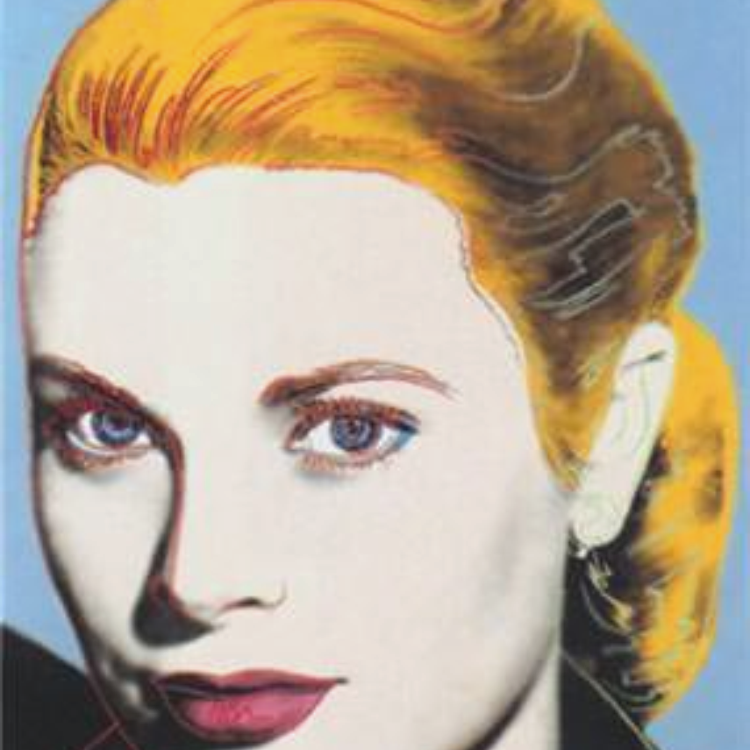

In [39]:
# Display an example image
images, labels = next(iter(train_dataloader))
transforms.functional.to_pil_image(images[15])

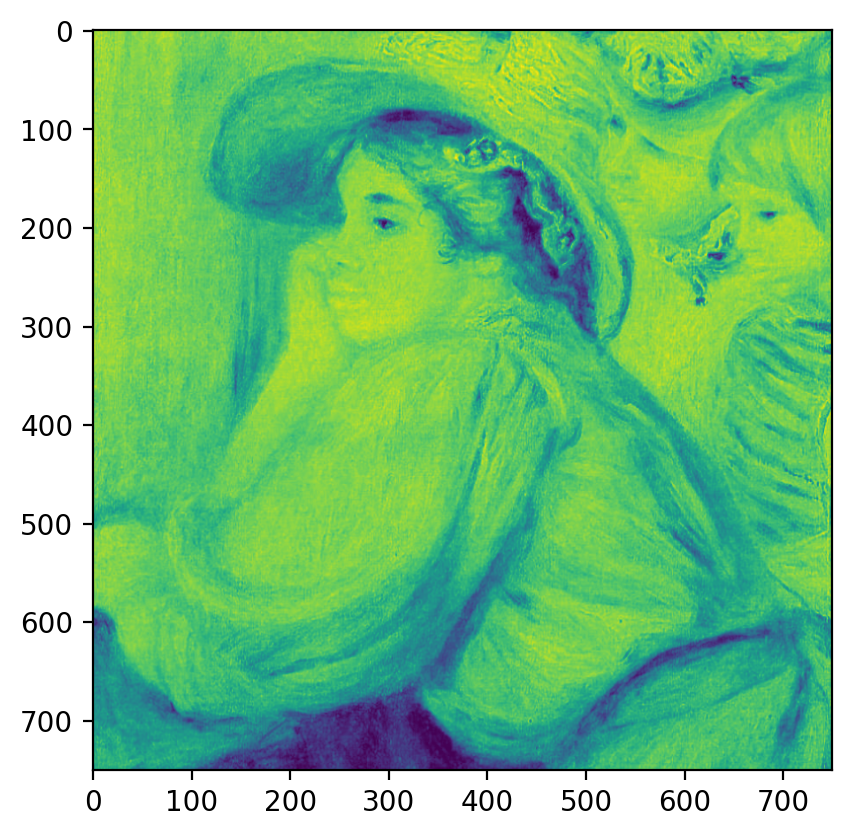

The label of the image is: 39


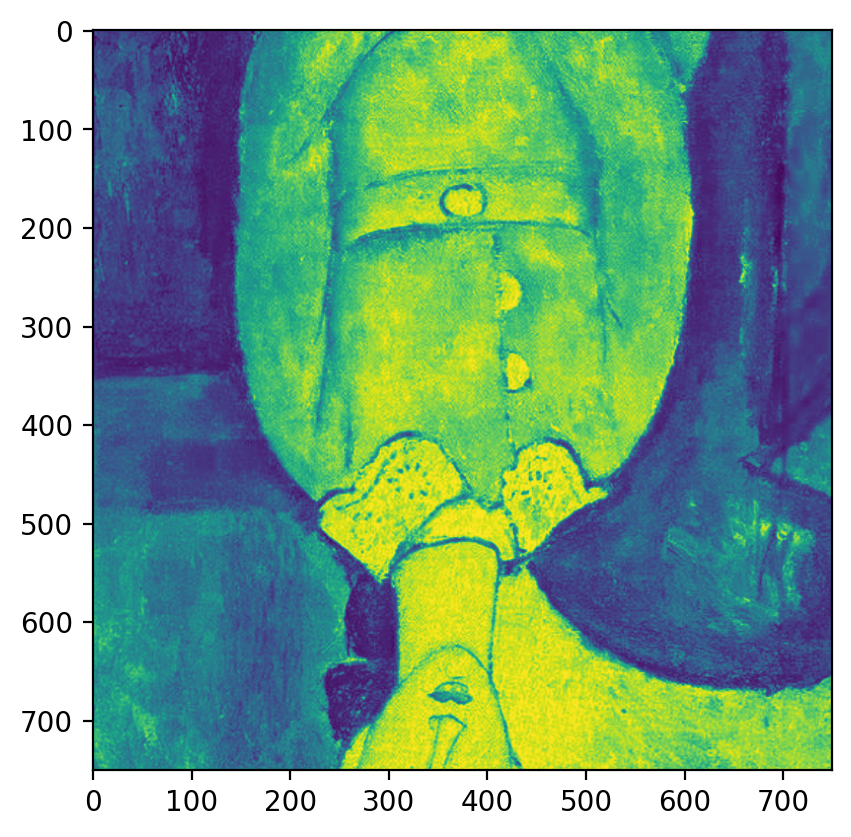

The label of the image is: 3


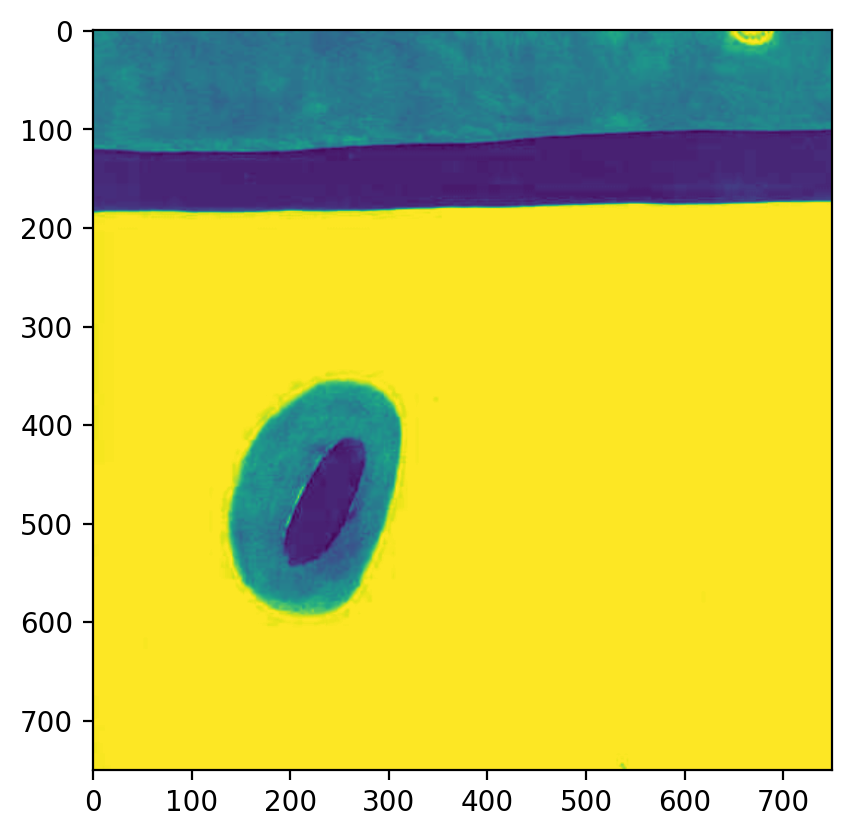

The label of the image is: 28


In [40]:
import random

# Print 3 random images in their augmented and normalized state

rand_numer1 = random.randint(0,25338)
plt.imshow(dataset_train[rand_numer1][0][0])
plt.show()
print("The label of the image is:", dataset_train[rand_numer1][1])

rand_numer2 = random.randint(0,25338)
plt.imshow(dataset_train[rand_numer2][0][0])
plt.show()
print("The label of the image is:", dataset_train[rand_numer2][1])

rand_numer3 = random.randint(0,25338)
plt.imshow(dataset_train[rand_numer3][0][0])
plt.show()
print("The label of the image is:", dataset_train[rand_numer3][1])

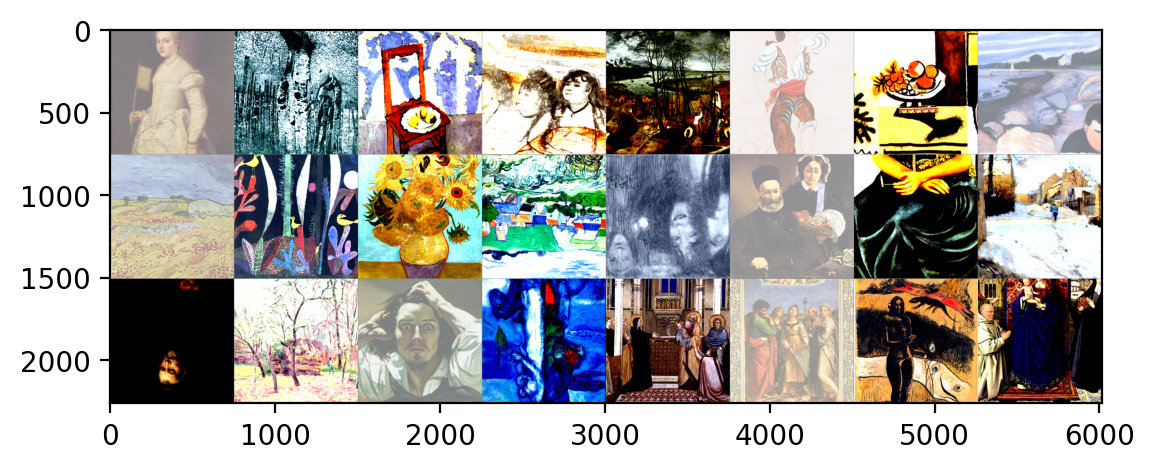

Titian Gustav_Klimt Henri_Matisse Edgar_Degas


In [41]:
batch_size = 4
import numpy as np

# show image unnormalized
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_dataloader))
# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Import Artists

In [42]:
# import artists data
artists = pd.read_csv(data_dir + '/artists.csv')
artists.shape

(50, 8)

In [43]:
# display some of the artists sorted by number of paintings
artists.sort_values(by='paintings').head()

id              name        years                   genre nationality  \
49  49   Jackson Pollock  1912 – 1956  Abstract Expressionism    American   
39  39  Eugene Delacroix  1798 – 1863             Romanticism      French   
41  41    Georges Seurat  1859 – 1891      Post-Impressionism      French   
38  38      Paul Cezanne  1839 – 1906      Post-Impressionism      French   
48  48      Michelangelo  1475 – 1564        High Renaissance     Italian   

                                                  bio  \
49  Paul Jackson Pollock (; January 28, 1912 – Aug...   
39  Ferdinand Victor Eugène Delacroix (; French: [...   
41  Georges-Pierre Seurat (French: [ʒɔʁʒ pjɛʁ sœʁa...   
38  Paul Cézanne (US:  or UK: ; French: [pɔl sezan...   
48  Michelangelo di Lodovico Buonarroti Simoni or ...   

                                         wikipedia  paintings  
49    http://en.wikipedia.org/wiki/Jackson_Pollock         24  
39  https://en.wikipedia.org/wiki/Eugène_Delacroix         31  
41    https://en.wikipedia.org/wiki/Georges_Seurat         43  
38      https://en.wikipedia.org/wiki/Paul_Cézanne         47  
48      https://en.wikipedia.org/wiki/Michelangelo         49

# Load the neural network

In [44]:
import torch.nn as nn
import torch.nn.functional as F

In [45]:
# Empty cuda cache
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 434715 KiB |   8729 MiB | 596738 MiB | 596313 MiB |\n|       from large pool | 416632 KiB |   8717 MiB | 596650 MiB | 596243 MiB |\n|       from small pool |  18083 KiB |     17 MiB |     87 MiB |     70 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 434715 KiB |   8729 MiB | 596738 MiB | 596313 MiB |\n|       from large pool | 416632 KiB |   8717 MiB |

In [46]:
# Load pretrained neural network we can test it on different neural networks.

# net = torchvision.models.resnet18(pretrained=True)
net = torch.hub.load('pytorch/vision:v0.11.0', 'resnet34', pretrained=True)
# net = torchvision.models.vgg16(pretrained=True)
# net = net.cuda() if torch.device else net

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.11.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Define loss and optimizer and then Train

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.optim as optim

# set criterion to cross entropy loss and optimizer to stochastic gradient descent
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Move model and data to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# loop over the dataset multiple times
for epoch in range(5):  

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        # Move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 0.5)
        optimizer.step() 

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.116


KeyboardInterrupt: 

In [27]:
# Save the model to disk
PATH = '/kaggle/input/clemodel/pytorch/clemodel/1.pth'
torch.save(net.state_dict(), PATH)

RuntimeError: File /kaggle/input/clemodel/pytorch/clemodel/1.pth cannot be opened.

# Test the Network

In [51]:
import torchvision
from torchvision import transforms

# Assuming 'classes' variable holds the class names

# Get an iterator for the test DataLoader
data_iter = iter(test_dataloader)

# Extract a batch of data
images, labels = next(data_iter)

# Print images
transforms.functional.to_pil_image(torchvision.utils.make_grid(images))

# Print ground truth labels
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

GroundTruth:  Vincent_van_Gogh Edouard_Manet Pierre-Auguste_Renoir Amedeo_Modigliani Hieronymus_Bosch Andy_Warhol Rembrandt Jackson_Pollock Pierre-Auguste_Renoir Andrei_Rublev Frida_Kahlo Edgar_Degas Claude_Monet Pablo_Picasso Amedeo_Modigliani Albrecht_Dürer Mikhail_Vrubel Sandro_Botticelli Alfred_Sisley El_Greco Marc_Chagall Vincent_van_Gogh Pablo_Picasso Paul_Gauguin


In [52]:
# Load trained model from file
net.load_state_dict(torch.load('/kaggle/input/dl-model/pytorch/model/1/CELmodel.pth'))

<All keys matched successfully>

In [53]:
# Make predictions
outputs = net(images.to(torch.device('cuda')))

In [54]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  Vincent_van_Gogh Edouard_Manet Pierre-Auguste_Renoir Amedeo_Modigliani


# Accuracy

In [55]:
correct = 0
total = 0

# Calculate accuracy user test data
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(torch.device('cuda')))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(torch.device('cuda'))).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 75 %


# Accuracy by Class

In [56]:
# Calculate accuracy by class
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images.to(torch.device('cuda')))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels.to(torch.device('cuda')), predictions):
          if label == prediction:
              correct_pred[classes[label]] += 1
          # else:
          #   if classes[label] == 'Albrecht_Dürer':
          #     print('incorrect: ', classes[label], '!=', classes[prediction])
          total_pred[classes[label]] += 1


class_accuracies = []

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class Albrecht_Dürer is: 0.0 %
Accuracy for class Albrecht_Du╠êrer is: 96.2 %
Accuracy for class Alfred_Sisley is: 87.4 %
Accuracy for class Amedeo_Modigliani is: 87.0 %
Accuracy for class Andrei_Rublev is: 76.9 %
Accuracy for class Andy_Warhol is: 86.1 %
Accuracy for class Camille_Pissarro is: 44.4 %
Accuracy for class Caravaggio is: 63.6 %
Accuracy for class Claude_Monet is: 37.9 %
Accuracy for class Diego_Rivera is: 75.0 %
Accuracy for class Diego_Velazquez is: 72.5 %
Accuracy for class Edgar_Degas is: 91.8 %
Accuracy for class Edouard_Manet is: 47.2 %
Accuracy for class Edvard_Munch is: 57.7 %
Accuracy for class El_Greco is: 88.2 %
Accuracy for class Eugene_Delacroix is: 25.0 %
Accuracy for class Francisco_Goya is: 80.2 %
Accuracy for class Frida_Kahlo is: 85.4 %
Accuracy for class Georges_Seurat is: 76.5 %
Accuracy for class Giotto_di_Bondone is: 76.6 %
Accuracy for class Gustav_Klimt is: 56.5 %
Accuracy for class Gustave_Courbet is: 34.8 %
Accuracy for class Henri_M

In [57]:
classes_plot = []
accuracy_plot = []

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    
    classes_plot.append(classname)
    accuracy_plot.append(accuracy)

In [58]:
sorted_list = sorted(list(zip(classes_plot, accuracy_plot)), key=lambda x: x[1], reverse=True)

In [59]:
classes_sorted, accuracies_sorted = map(list, zip(*sorted_list))

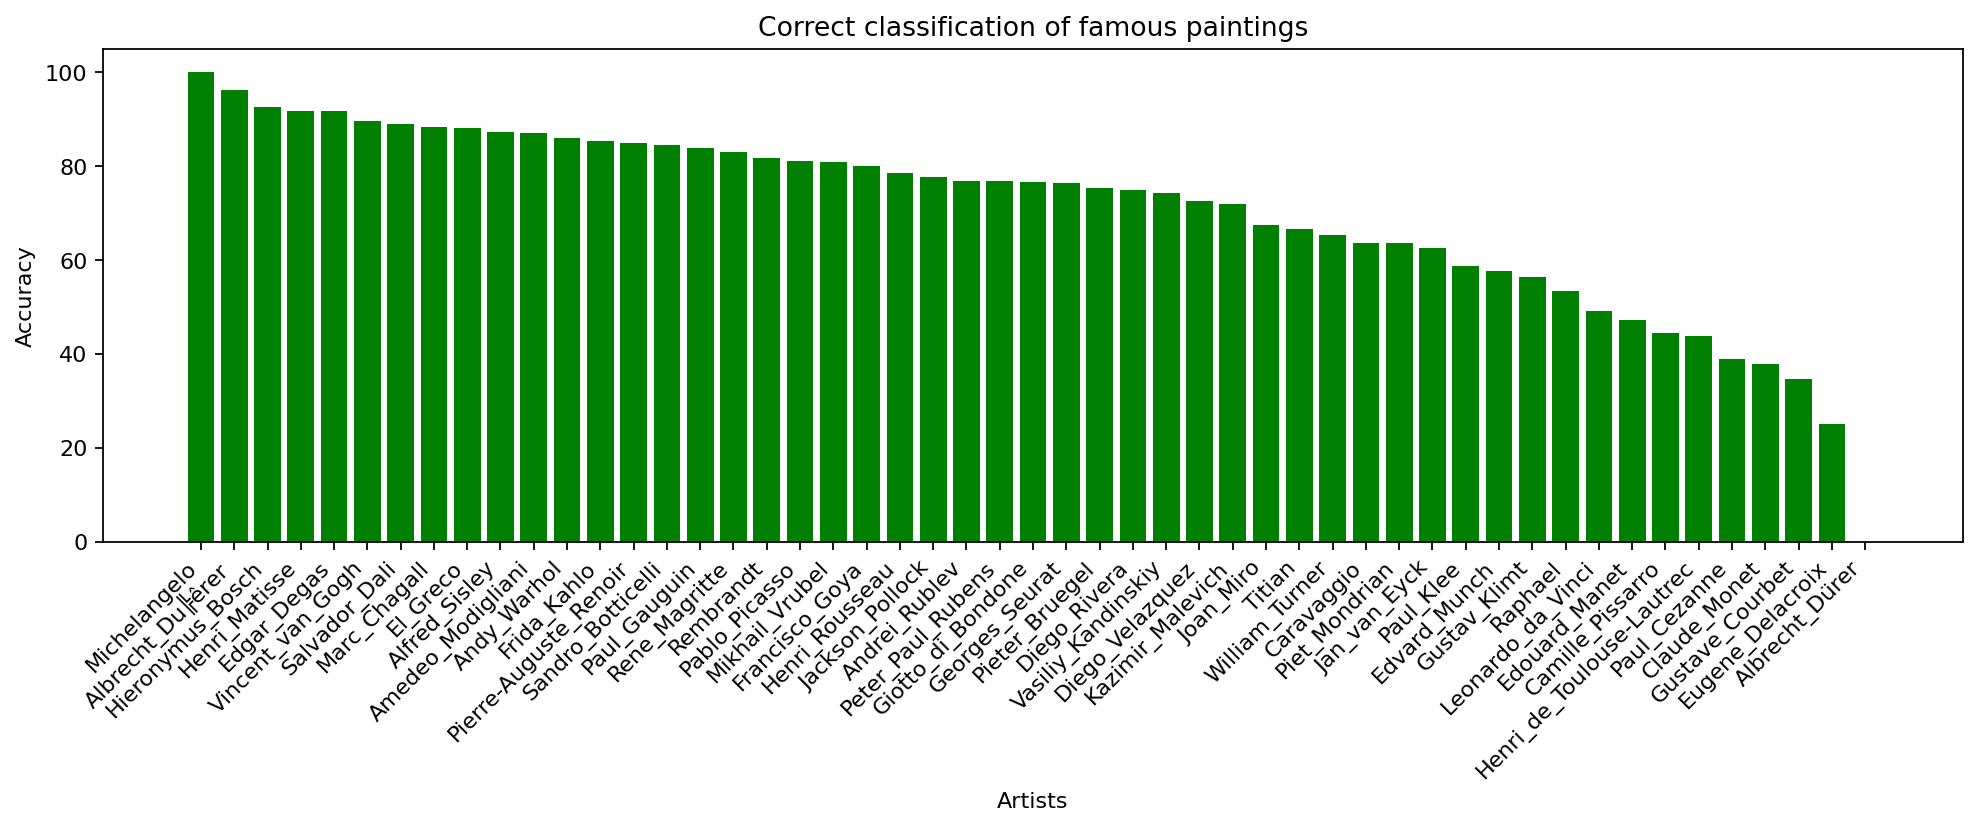

In [60]:
# Display accuracy by artist bar plot - sorted by accuracy
figure(figsize=(15, 4), dpi=80)

x_pos = [i for i, _ in enumerate(classes_sorted)]

plt.bar(x_pos, accuracies_sorted, color='green')
plt.xlabel("Artists")
plt.ylabel("Accuracy")
plt.title("Correct classification of famous paintings")

plt.xticks(x_pos, classes_sorted)
plt.xticks(rotation=45, ha="right")

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/required/check.png'

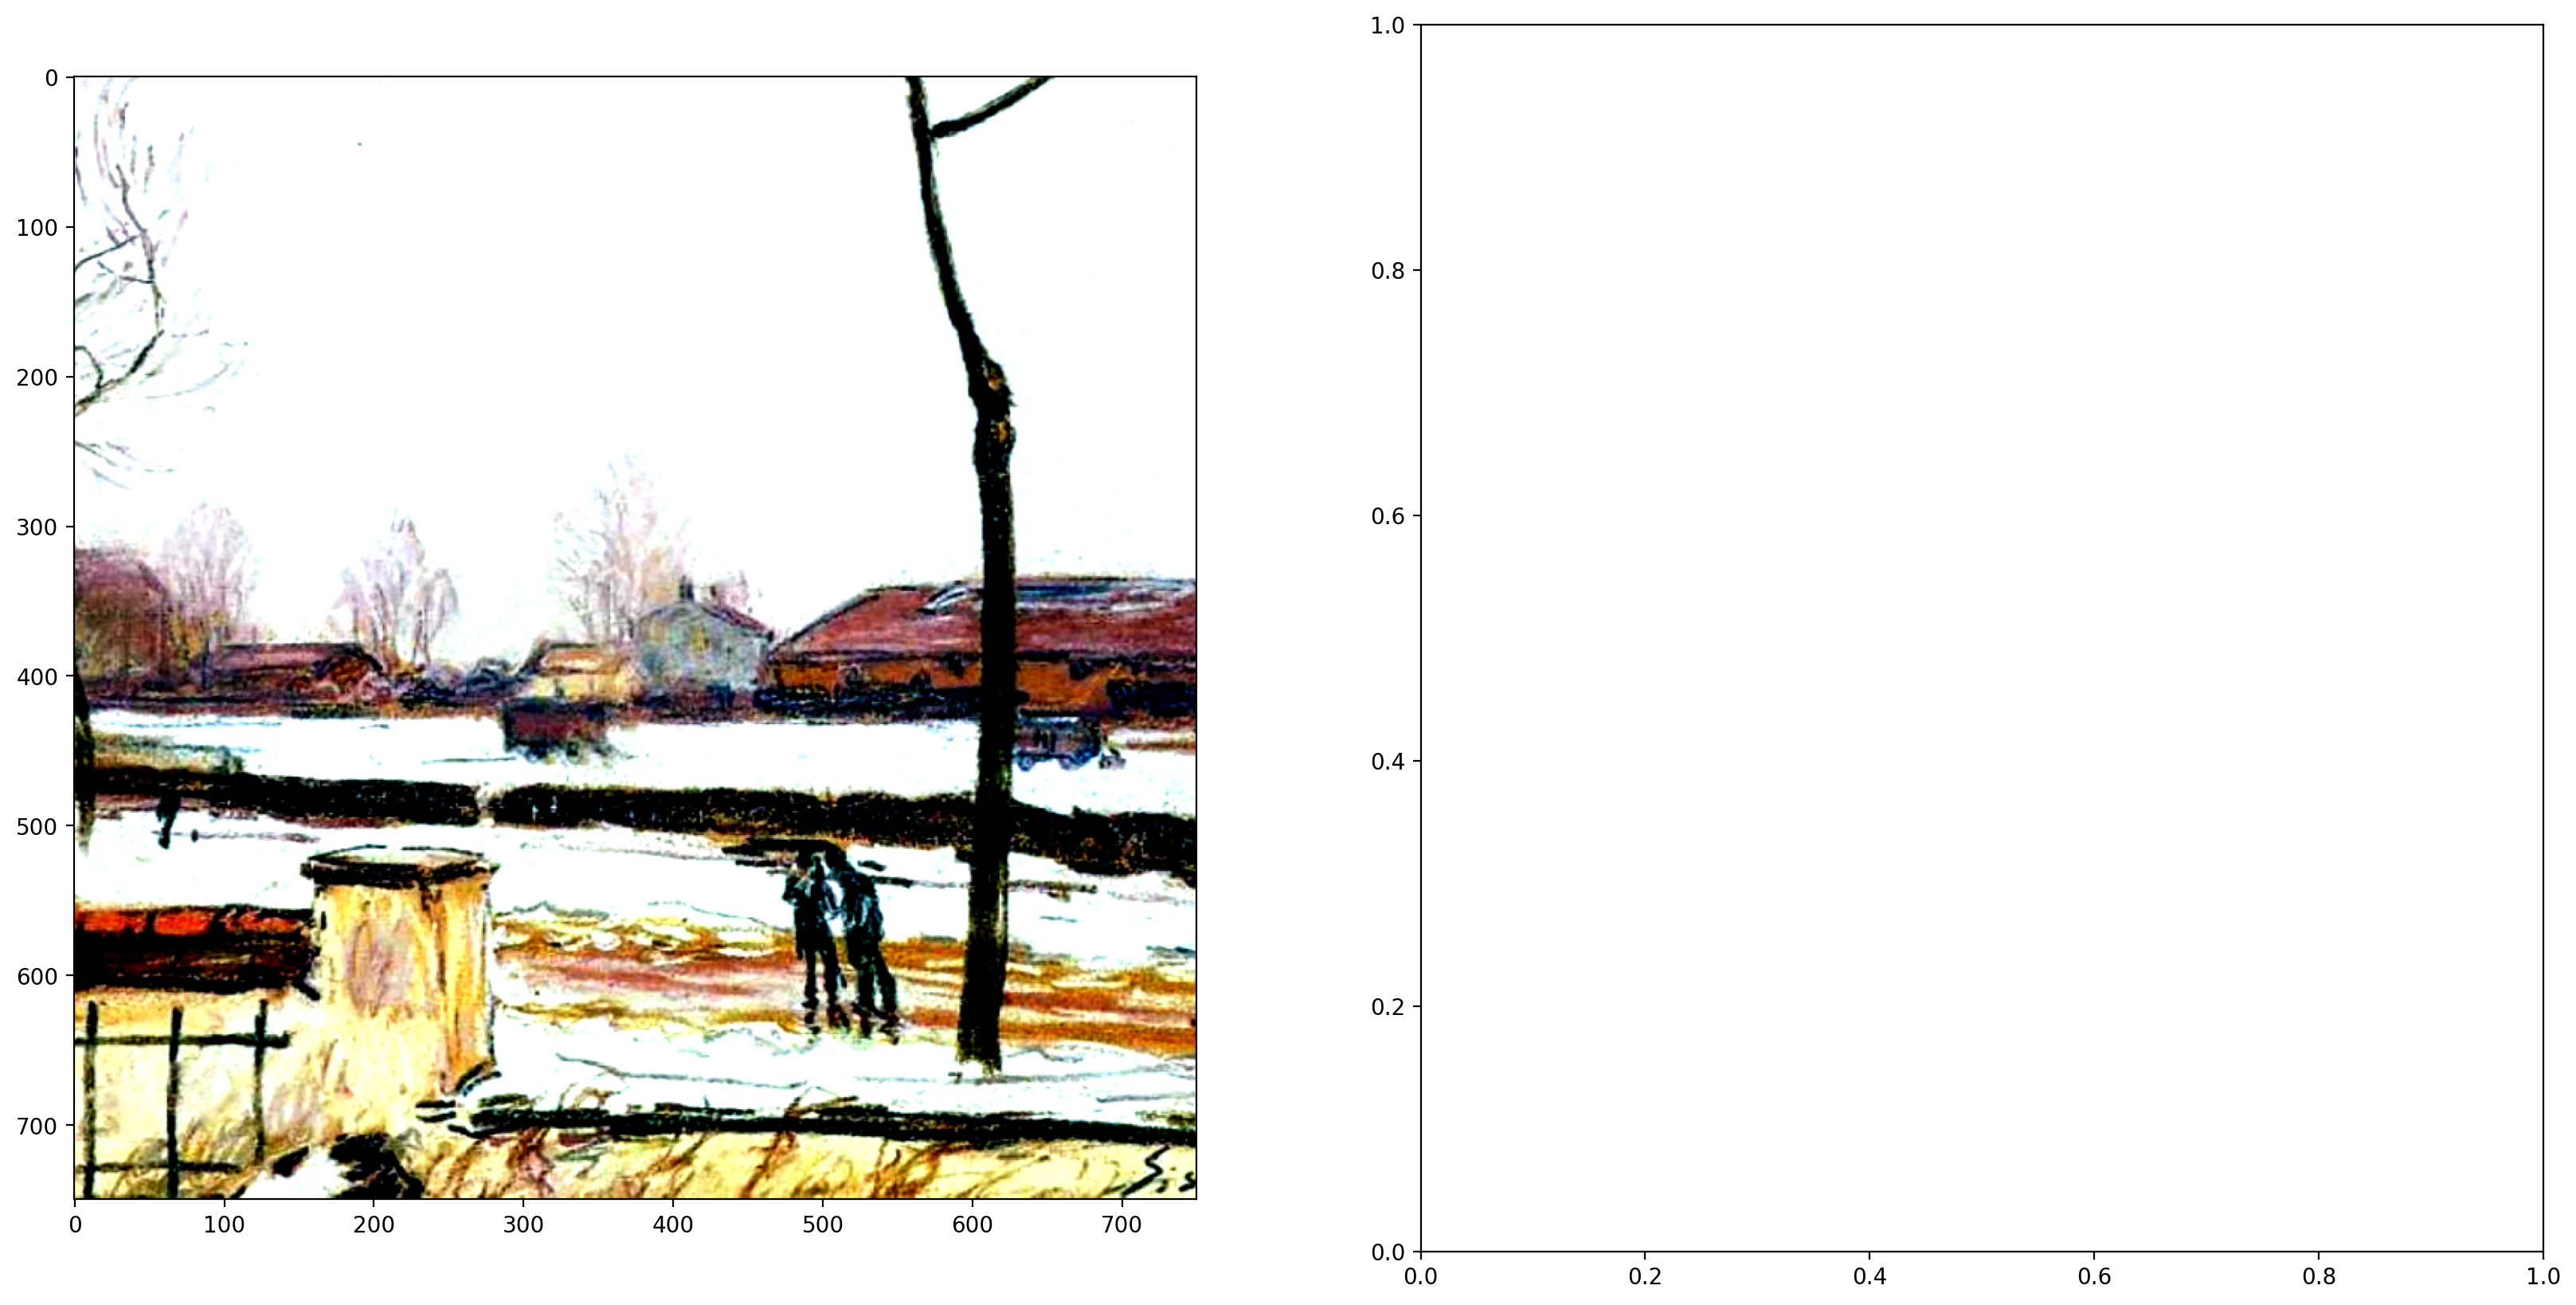

In [61]:
import matplotlib.image as mpimg

def imshow(img, ax):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

# DEMO
# Pick 4 random images, classify them and compare to label data
with torch.no_grad():
    for idx, data in enumerate(test_dataloader):
        images, labels = data
        outputs = net(images.to(torch.device('cuda')))
        _, predictions = torch.max(outputs, 1)

        if idx == 5 or idx == 10 or idx == 20 or idx == 30:
          f, axes = plt.subplots(1, 2, figsize=(20, 10))
          imshow(images[1], axes[0])
          
          if classes[labels[1]] == classes[predictions[1]]:
            axes[1].imshow(mpimg.imread('/kaggle/input/required/check.png'))
          else:
            axes[1].imshow(mpimg.imread('/kaggle/input/required/cross.png'))
          
          plt.show()
          print("The label of the image is:", classes[labels[1]])
          print("The prediction of the image is:", classes[predictions[1]], "\n\n")

In [33]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [39]:
class MetaLearner:
    def __init__(self, model, criterion, meta_optimizer, meta_lr=0.001, inner_lr=0.01, num_inner_updates=1):
        self.model = model
        self.criterion = criterion
        self.meta_optimizer = meta_optimizer
        self.meta_lr = meta_lr
        self.inner_lr = inner_lr
        self.num_inner_updates = num_inner_updates

    def meta_train(self, meta_train_dataloader, meta_val_dataloader, num_iterations):
        for iteration in range(num_iterations):
            meta_gradients = 0
            for task in meta_train_dataloader:
                support_set, query_set = task['support'], task['query']
                for inner_update in range(self.num_inner_updates):
                    # Perform inner loop update
                    support_inputs, support_labels = support_set
                    support_inputs, support_labels = support_inputs.to(device), support_labels.to(device)
                    self.model.zero_grad()
                    outputs = self.model(support_inputs)
                    loss = self.criterion(outputs, support_labels)
                    loss.backward()
                    with torch.no_grad():
                        for param in self.model.parameters():
                            param -= self.inner_lr * param.grad
                
                # Evaluate on query set
                query_inputs, query_labels = query_set
                query_inputs, query_labels = query_inputs.to(device), query_labels.to(device)
                outputs = self.model(query_inputs)
                loss = self.criterion(outputs, query_labels)
                loss.backward()
                meta_gradients += self.model.parameters.grad

            # Meta-update
            self.meta_optimizer.zero_grad()
            meta_gradients /= len(meta_train_dataloader)
            for param in self.model.parameters():
                param.grad = meta_gradients
            self.meta_optimizer.step()

    def evaluate(self, dataloader):
        # Evaluate the model on a dataloader
        pass

In [40]:
# Set the meta-learning rate
meta_lr = 0.001  # You can adjust this value based on experimentation

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# Set up meta-optimizer with the specified meta-learning rate
meta_optimizer = optim.SGD(net.parameters(), lr=meta_lr)

# Meta-learning parameters
inner_lr = 0.01
num_inner_updates = 1

# Initialize MetaLearner
meta_learner = MetaLearner(model=net, criterion=criterion, meta_optimizer=meta_optimizer,
                           meta_lr=meta_lr, inner_lr=inner_lr, num_inner_updates=num_inner_updates)

# Meta-train the model
num_iterations = 100  # You can adjust this
meta_learner.meta_train(meta_train_dataloader=train_dataloader, meta_val_dataloader=test_dataloader, num_iterations=num_iterations)

TypeError: list indices must be integers or slices, not str

In [24]:
# Load the pretrained model
net = torchvision.models.resnet34(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 144MB/s] 


In [27]:
# Change the final layer to match the number of artists
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, len(classes_train))

In [28]:
# Meta-learning parameters
inner_lr = 0.01  # Learning rate for inner loop (task-specific adaptation)
outer_lr = 0.001  # Learning rate for outer loop (meta-update)
num_inner_steps = 5  # Number of gradient updates for task adaptation

In [29]:
# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=outer_lr)

In [31]:
# MAML Loop
def maml_train(model, epochs, dataloader, optimizer, criterion, num_inner_steps, inner_lr):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            # Save the initial parameters for meta-update
            initial_parameters = copy.deepcopy(model.state_dict())

            # Inner loop: Task-specific adaptation
            for _ in range(num_inner_steps):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                model.zero_grad()
                loss.backward()
                optimizer.step()

            # Outer loop
            meta_loss = criterion(model(inputs), labels)
            model.load_state_dict(initial_parameters)  # Revert to initial parameters

            optimizer.zero_grad()
            meta_loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += meta_loss.item()
            if i % 10 == 9:
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3f}')
                running_loss = 0.0

        print(f'Finished Epoch {epoch + 1}')

In [32]:
# Training with MAML
maml_train(net, 5, train_dataloader, optimizer, criterion, num_inner_steps, inner_lr)

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [512, 51]], which is output 0 of AsStridedBackward0, is at version 7; expected version 6 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).